## K-Nearest-Neighbors

KNN falls in the supervised learning family of algorithms. Informally, this means that we are given a labelled dataset consiting of training observations (x,y) and would like to capture the relationship between x and y. More formally, our goal is to learn a function h:X→Y so that given an unseen observation x, h(x) can confidently predict the corresponding output y.

In this module we will explore the inner workings of KNN, choosing the optimal K values and using KNN from scikit-learn.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormapimport seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')   
pd.options.display.float_format = '{:.6f}'.format
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix, roc_curve, accuracy_score, f1_score, log_loss, roc_auc_score

from pandas.api.types import is_string_dtype
from sklearn.feature_selection import RFE

plt.rcParams['figure.figsize'] = [15,8]

from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import ttest_ind,chi2_contingency
from pandas.core.common import random_state
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB

## Problem statement

### Dataset

The data set we’ll be using is the Iris Flower Dataset which was first introduced in 1936 by the famous statistician Ronald Fisher and consists of 50 observations from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals.

**Source:** https://archive.ics.uci.edu/ml/datasets/Iris

**Train the KNN algorithm to be able to distinguish the species from one another given the measurements of the 4 features.**

## Question 1

#### Read the iris.csv file

In [2]:
df_iris = pd.read_csv('iris.csv')
df_iris.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.100000,3.500000,1.400000,0.200000,Iris-setosa
1,2,4.900000,3.000000,1.400000,0.200000,Iris-setosa
2,3,4.700000,3.200000,1.300000,0.200000,Iris-setosa
3,4,4.600000,3.100000,1.500000,0.200000,Iris-setosa
4,5,5.000000,3.600000,1.400000,0.200000,Iris-setosa


## Data Pre-processing

## Question 2 - Estimating missing values

*Its not good to remove the records having missing values all the time. We may end up loosing some data points. So, we will have to see how to replace those missing values with some estimated values (median) *

In [3]:
df_iris.isnull().sum()/len(df_iris) * 100

Id              0.000000
SepalLengthCm   0.657895
SepalWidthCm    1.315789
PetalLengthCm   1.315789
PetalWidthCm    0.657895
Species         0.000000
dtype: float64

In [4]:
df_iris.skew()

Id               0.000000
SepalLengthCm    0.314543
SepalWidthCm     0.334053
PetalLengthCm   -0.274464
PetalWidthCm    -0.117256
dtype: float64

In [5]:
df_target = df_iris['Species']
df_feature = df_iris.drop('Species', axis = 1)
df_feature.set_index('Id', inplace=True)
df_feature.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
Id,,,,
1,5.100000,3.500000,1.400000,0.200000
2,4.900000,3.000000,1.400000,0.200000
3,4.700000,3.200000,1.300000,0.200000
4,4.600000,3.100000,1.500000,0.200000
5,5.000000,3.600000,1.400000,0.200000


In [ ]:
#We have divided independent and dependent variables and Id has been set as index and below is 
#replacing Null values with median of columns as they are lightly skewed

In [6]:
for col in df_feature.columns:
    df_feature[col].fillna(df_feature[col].median(), inplace = True)
df_feature.isnull().sum()/len(df_feature) * 100

SepalLengthCm   0.000000
SepalWidthCm    0.000000
PetalLengthCm   0.000000
PetalWidthCm    0.000000
dtype: float64

## Question 3 - Dealing with categorical data

Change all the classes to numericals (0to2).

In [7]:
df_target.value_counts()

Iris-virginica     52
Iris-setosa        50
Iris-versicolor    50
Name: Species, dtype: int64

In [8]:
for i in range(len(df_target)):
    if df_target[i] == 'Iris-virginica':
        df_target[i] = 0
    elif df_target[i] == 'Iris-versicolor':
        df_target[i] = 1
    else:
        df_target[i] = 2
df_target = df_target.astype('int')  

In [9]:
df_target.value_counts()

0    52
1    50
2    50
Name: Species, dtype: int64

## Question 4

*Observe the association of each independent variable with target variable and drop variables from feature set having correlation in range -0.1 to 0.1 with target variable.*

In [10]:
df_feature.corrwith(df_target)

SepalLengthCm   -0.769726
SepalWidthCm     0.418612
PetalLengthCm   -0.937616
PetalWidthCm    -0.943416
dtype: float64

In [ ]:
Inference : we can see all are correlated with target variable so, no one in range of -0.1 to 0.1 so 
    each feature is important for prediction

## Question 5

*Observe the independent variables variance and drop such variables having no variance or almost zero variance(variance < 0.1). They will be having almost no influence on the classification.*

In [11]:
df_feature.var()

SepalLengthCm   0.676645
SepalWidthCm    0.185552
PetalLengthCm   3.076516
PetalWidthCm    0.577141
dtype: float64

In [ ]:
#Inference : We can see all variables having >0.1 variance so all are important for prediction

## Question 6

*Plot the scatter matrix for all the variables.*

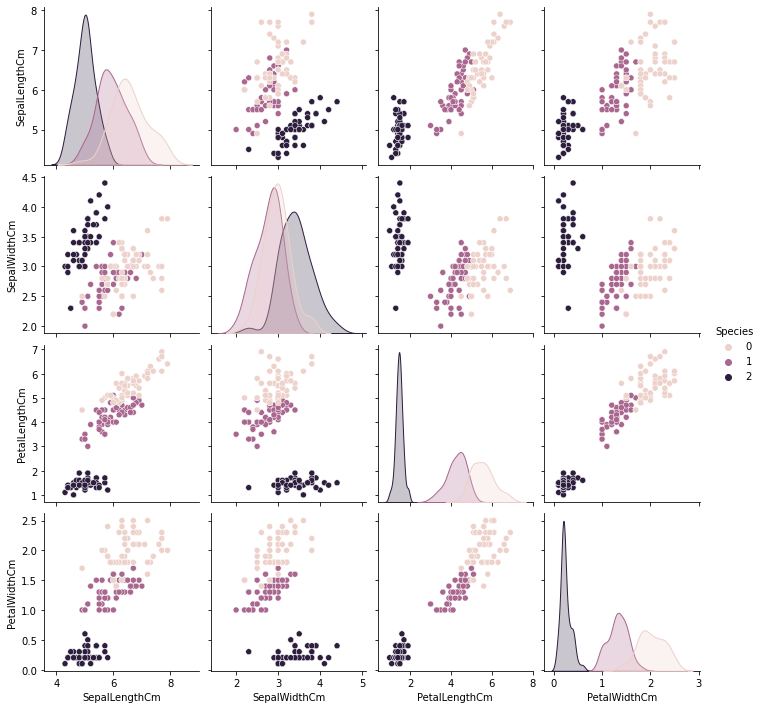

In [12]:
sns.pairplot(data = df_iris.drop('Id', axis = 1), hue = 'Species')

## Split the dataset into training and test sets

## Question 7

*Split the dataset into training and test sets with 80-20 ratio.*

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df_feature, df_target, random_state = 10,test_size = 0.2)
print('X_train', X_train.shape)
print('y_train', y_train.shape)

print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (121, 4)
y_train (121,)
X_test (31, 4)
y_test (31,)


## Question 8 - Model

*Build the model and train and test on training and test sets respectively using **scikit-learn**. Print the Accuracy of the model with different values of **k=3,5,9**.*

**Hint:** For accuracy you can check **accuracy_score()** in scikit-learn

In [14]:
for k in [3,5,9]:
    knn_classification = KNeighborsClassifier(n_neighbors = k)
    knn_model = knn_classification.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    print("Accuracy for {} neighbors:".format(k), accuracy_score(y_test, y_pred))

Accuracy for 3 neighbors: 0.9354838709677419
Accuracy for 5 neighbors: 0.9354838709677419
Accuracy for 9 neighbors: 0.9354838709677419


## Question 9 - Cross Validation

Run the KNN with no of neighbours to be 1,3,5..19 and *Find the **optimal number of neighbours** from the above list using the Mis classification error

Hint:

Misclassification error (MSE) = 1 - Test accuracy score. Calculated MSE for each model with neighbours = 1,3,5...19 and find the model with lowest MSE

In [15]:
n_neighbors = np.arange(1,20)
misclassification_errors = []
for k in n_neighbors:
    knn_classification = KNeighborsClassifier(n_neighbors = k)
    knn_model = knn_classification.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    accu_score = accuracy_score(y_test, y_pred)
    misclassification_errors.append(1 - accu_score)    
    
mse_df = pd.DataFrame({'K': n_neighbors, 'MSE': misclassification_errors})
lowest_mse = mse_df.sort_values('MSE', ascending=True).iloc[0,1]
print('optimal number of neighbours :', mse_df[mse_df['MSE'] == lowest_mse].K.to_list())
print('Lowest MSE :', lowest_mse)

optimal number of neighbours : [1, 3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Lowest MSE : 0.06451612903225812


In [16]:
mse_df.sort_values('MSE', ascending=True)

,K,MSE
0,1,0.064516
16,17,0.064516
15,16,0.064516
14,15,0.064516
13,14,0.064516
12,13,0.064516
11,12,0.064516
10,11,0.064516
17,18,0.064516
9,10,0.064516


## Question 10

*Plot misclassification error vs k (with k value on X-axis) using matplotlib.*

Text(0, 0.5, 'Misclassification error (MSE)')

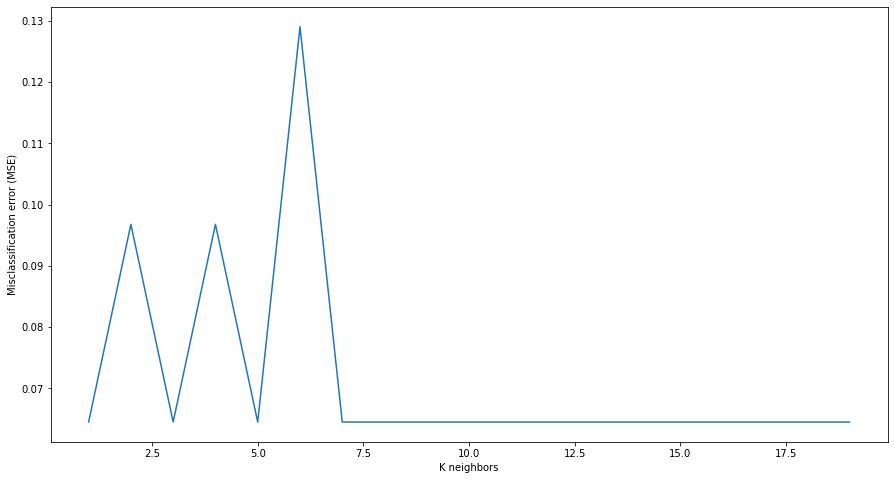

In [17]:
plt.plot(mse_df['K'], mse_df['MSE'])
plt.xlabel('K neighbors')
plt.ylabel('Misclassification error (MSE)')

# Naive Bayes

In [18]:
#Load all required library
from sklearn.naive_bayes import GaussianNB

### Question 1
#### Import Iris.csv

In [19]:
df_iris = pd.read_csv('iris.csv')
df_iris.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.100000,3.500000,1.400000,0.200000,Iris-setosa
1,2,4.900000,3.000000,1.400000,0.200000,Iris-setosa
2,3,4.700000,3.200000,1.300000,0.200000,Iris-setosa
3,4,4.600000,3.100000,1.500000,0.200000,Iris-setosa
4,5,5.000000,3.600000,1.400000,0.200000,Iris-setosa


### Question 2
#### Slice data set for Independent variables and dependent variables
#### Please note 'Species' is my dependent variables, name it y and independent set data as X

In [20]:
y = df_iris['Species']
for i in range(len(y)):
    if y[i] == 'Iris-virginica':
        y[i] = 0
    elif y[i] == 'Iris-versicolor':
        y[i] = 1
    else:
        y[i] = 2
y = y.astype('int') 
X = df_iris.drop(['Id', 'Species'], axis = 1)

## Question 3
#### Find the distribution of target variable (Class)
#### And, Plot the distribution of target variable using histogram

<AxesSubplot:xlabel='Species', ylabel='Count'>

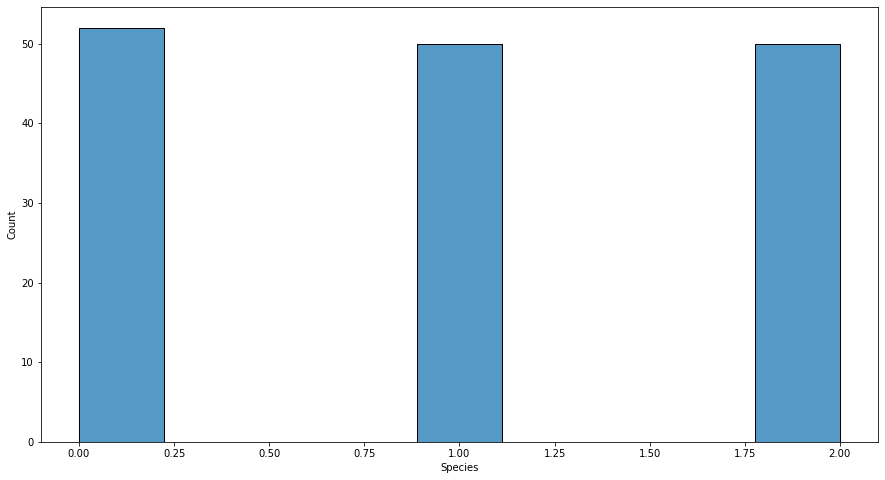

In [21]:
sns.histplot(y)

### Plot the distribution of target variable using histogram

<AxesSubplot:xlabel='Species', ylabel='Count'>

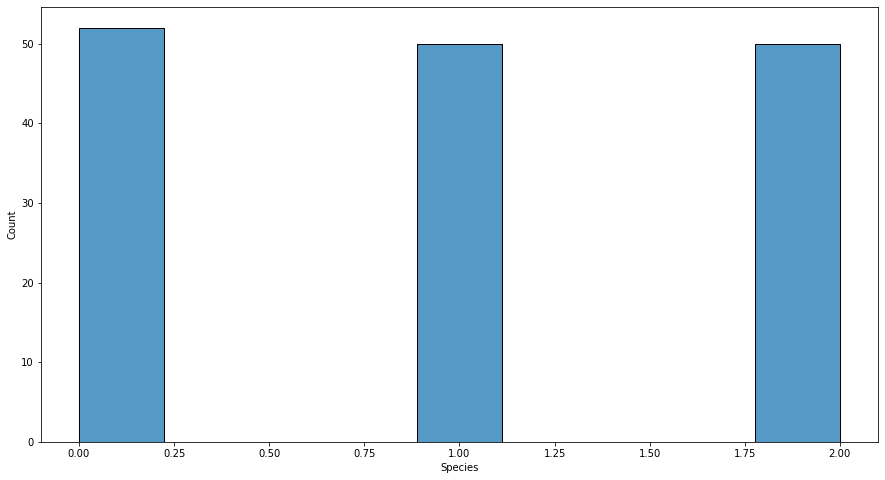

In [22]:
sns.histplot(y)

### Plot Scatter Matrix to understand the distribution of variables and give insights from it.

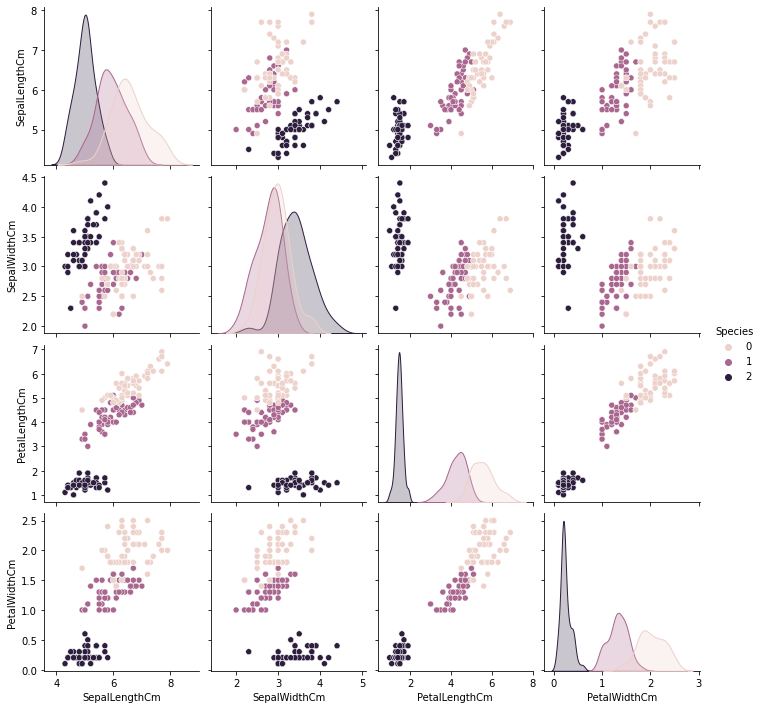

In [23]:
sns.pairplot(data = df_iris.drop('Id' , axis = 1), hue = 'Species')

In [ ]:
#We can see Iris-virginica having larger lengths other than Species and having high positive correlation 
#between PetalLengthCm and PetalWidthCm

#We can see there is high positive correlation between PetalLengthCm and PetalWidthCm with SepalLengthCm, 
#PetalWidthCm with PetalLengthCm

#Moderate negative correlation between PetalLengthCm and PetalWidthCm with SepalWidthCm

#Low negative correlation between SepalWidthCm with SepalLengthCm

### Question 3
#### Find Correlation among all variables and give your insights 

In [24]:
df_iris.drop('Id', axis = 1).corr()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
SepalLengthCm,1.000000,-0.109369,0.871754,0.817954
SepalWidthCm,-0.109369,1.000000,-0.420516,-0.356544
PetalLengthCm,0.871754,-0.420516,1.000000,0.962757
PetalWidthCm,0.817954,-0.356544,0.962757,1.000000


In [ ]:
#We can see there is high positive correlation between PetalLengthCm and PetalWidthCm with SepalLengthCm,
#PetalWidthCm with PetalLengthCm

#Moderate negative correlation between PetalLengthCm and PetalWidthCm with SepalWidthCm

#Low negative correlation between SepalWidthCm with SepalLengthCm

### Question 4
#### Split data in Training and Validation in 80:20

In [25]:
### SPLITTING INTO TRAINING AND TEST SETS
for col in X.columns:
    X[col].fillna(X[col].median(), inplace = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,random_state=10)

### Question 5
#### Do Feature Scaling 

In [26]:
SS = StandardScaler()
columns = X_train.columns
X_train_scaled = SS.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = columns)
columns = X_test.columns
X_test_scaled = SS.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = columns)

### Question 6 
#### Train and Fit NaiveBayes Model

In [27]:
gnb = GaussianNB()
gnb_model = gnb.fit(X_train_scaled, y_train)

### Question 7
#### Print Accuracy and Confusion Matrix and Conclude your findings

In [28]:
y_pred = gnb_model.predict(X_test_scaled)
print('Accuracy :', accuracy_score(y_test, y_pred))

Accuracy : 0.967741935483871


In [29]:
confusion_matrix(y_test, y_pred)

array([[ 9,  1,  0],
       [ 0, 13,  0],
       [ 0,  0,  8]], dtype=int64)

In [31]:
#Inference : We can see the accuracy i.e 0.9677 and we can say good model, for confusion matrix only one record predicted 
#as wrong remains all are predicted as correctly